Fig. 5: Benchmarking (Velocyto)
----
Runs Velocyto and visualizes the initial and terminal states.

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import cellrank as cr
import scanpy as sc
import velocyto as vcy
import scvelo as scv
import loompy

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+gc8c2b9f6 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.0 numba==0.54.0 scipy==1.7.1 pandas==1.3.2 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.0+gc8c2b9f6, on 2021-09-21 16:45.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR / "fig_5_benchmarking" / "velocyto")
scv.settings.plot_prefix = ''
scv.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Velocyto parameters:

In [6]:
k = 100  # number of neighbors for KNN graph
n_jobs = 8

## Define utility functions

In [7]:
def load_data(fpath: str):
    ds = loompy.connect(fpath)
    vlm = object.__new__(vcy.VelocytoLoom)

    vlm.loom_filepath = None
    vlm.S = ds.layer["spliced"][:, :]
    vlm.U = ds.layer["unspliced"][:, :]
    vlm.A = None
    vlm.ca = dict(ds.col_attrs.items())
    vlm.ra = dict(ds.row_attrs.items())
    ds.close()
    del ds
    vlm.initial_cell_size = vlm.S.sum(0)
    vlm.initial_Ucell_size = vlm.U.sum(0)
    
    return vlm

The below function to plot gene trends is copied from Palantir with slight modifications. 

## Load the data

Load the AnnData object from the CellRank software package. 

In [8]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata.write_loom(DATA_DIR / "pancreas" / "pancreas.loom")
adata

The loom file will lack these fields:
{'X_pca', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

### Plot the clusters and spliced/unspliced fractions

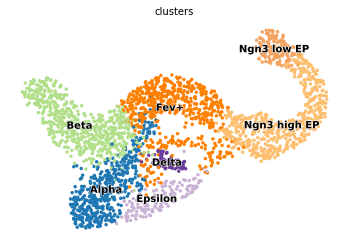

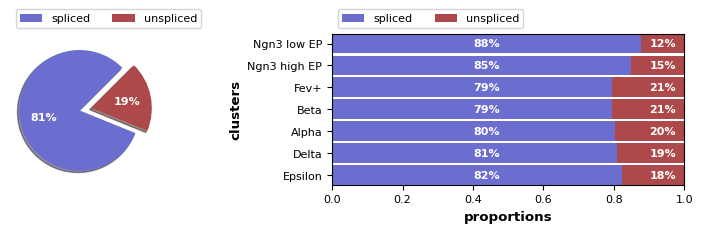

In [9]:
scv.pl.umap(adata, color='clusters')
scv.pl.proportions(adata)

## Initialize the Velocyto object

In [10]:
vlm = load_data(DATA_DIR / "pancreas" / "pancreas.loom")
vlm.ts = adata.obsm['X_umap']
vlm.cluster_labels = adata.obs['clusters']
vlm.colorandum = "black"

## Pre-process the data

In [11]:
vlm.score_detection_levels(min_expr_counts=15, min_expr_counts_U=10, min_cells_express=0)
vlm.filter_genes(by_detection_levels=True)
vlm.score_cv_vs_mean(3000)
vlm.filter_genes(by_cv_vs_mean=True)

vlm.normalize(size=True, log=True)

## Compute PCA and KNN imputation

This selects 21 principal components


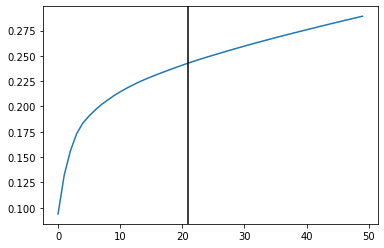

In [12]:
vlm.perform_PCA(n_components=50)

# use elbow heuristic to select the number of PCs
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
print(f"This selects {n_comps} principal components")

# provide the UMAP embedding
vlm.ts = adata.obsm['X_umap']

plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_))
plt.axvline(n_comps, c="k")

Inject the following lines in `velocyto/neighbors.py` starting at line 180:

- dsi = dsi.astype(np.int64)
- dist = dist.astype(np.float64)
- lsi = lsi.astype(np.int64)

(only when using balanced=True)

In [13]:
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=False, n_jobs=n_jobs,
                   b_sight=np.minimum(k * 8, vlm.S.shape[1] - 1),  # matters only for balanced
                   b_maxl=np.minimum(k * 4, vlm.S.shape[1] - 1))  # matters only for balanced

## Calculate the velocities

In [14]:
vlm.fit_gammas()
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t()

In [15]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1, n_jobs=n_jobs,
                             n_neighbors=k * 2, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift()
vlm.calculate_grid_arrows(steps=(40, 40), n_neighbors=k * 2)

## Plot the velocities on UMAP

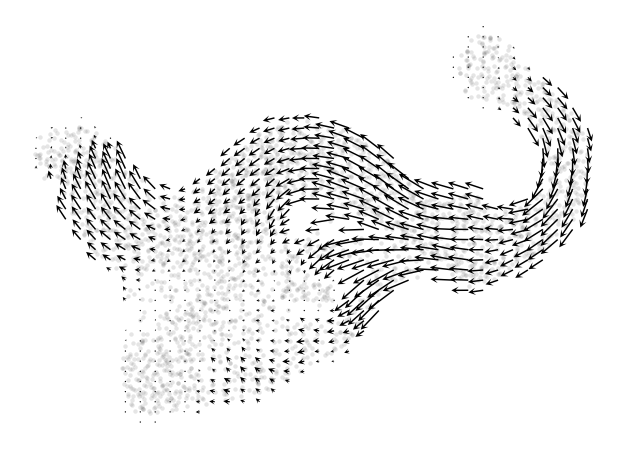

In [16]:
plt.figure(None,(24, 8))
plt.subplot(121)
vlm.plot_grid_arrows(quiver_scale=3.5,
                     scatter_kwargs_dict={"alpha": 0.1},
                     min_mass=1, angles='xy', scale_units='xy',
                     headaxislength=3, headlength=5, headwidth=5, minlength=1,
                     plot_random=False, scale_type="relative")
_ = plt.axis("off")

# Run Velocyto to compute initial and terminal states

## Subsample in the embedding

Directly taken from this [notebook](https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb).

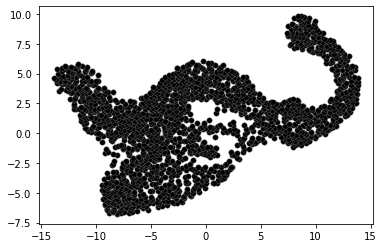

In [17]:
# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
if True:
    steps = 100, 100
    grs = []
    for dim_i in range(vlm.embedding.shape[1]):
        m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
        m = m - 0.025 * np.abs(M - m)
        M = M + 0.025 * np.abs(M - m)
        gr = np.linspace(m, M, steps[dim_i])
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors()
    nn.fit(vlm.embedding)
    dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

    diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
    min_dist = diag_step_dist / 2
    ixs = ixs[dist < min_dist]
    gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
    dist = dist[dist < min_dist]

    ixs = np.unique(ixs)

    vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                    c=vlm.colorandum, alpha=1, s=30, lw=0.4,
                    edgecolor="0.4")
    sigma_D = diag_step_dist
    sigma_W = diag_step_dist / 2.
else:
    sigma_D = 0.5
    sigma_W = 0.25
    ixs = np.arange(vlm.S.shape[1])

## Get the initial distribution

In [18]:
# starting_p = np.zeros(vlm.S.shape[1], dtype=np.float64)
# starting_p[np.where(vlm.cluster_labels == 'Ngn3 low EP')] = 1
# starting_p = starting_p[ixs]
# starting_p /= starting_p.sum()
# starting_p.sum()

# use uniform distribution, as done by velocyto. 
starting_p = np.ones(len(ixs))

## Run the forward diffusion

In [19]:
vlm.prepare_markov(sigma_D=sigma_D, sigma_W=sigma_W, direction='forward', cells_ixs=ixs)
vlm.run_markov(starting_p=starting_p, n_steps=2500)

## Plot results

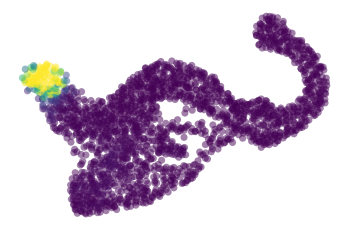

In [20]:
diffused_s = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_s /= np.percentile(diffused_s, 97)
diffused_s = np.clip(diffused_s, 0, 1)

vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_s, alpha=0.5, s=50, lw=0)
_ = plt.axis("off")

## Run the backward diffusion

In [21]:
vlm.prepare_markov(sigma_D=sigma_D, sigma_W=sigma_W, direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=starting_p, n_steps=2500)

## Plot results

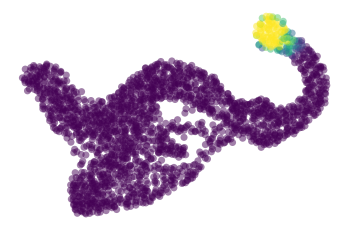

In [22]:
diffused_e = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_e /= np.percentile(diffused_e, 97)
diffused_e = np.clip(diffused_e, 0, 1)

vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_e, alpha=0.5, s=50, lw=0)
_ = plt.axis("off")

## Plot both in the same plot

In [23]:
ln = cr.tl.Lineage(np.c_[diffused_s, diffused_e], names=['end', 'start'])

Trying to set attribute `.obs` of view, copying.


saving figure to file /opt/projects/helmholtz/cellrank_reproducibility_2/figures/start_end.pdf


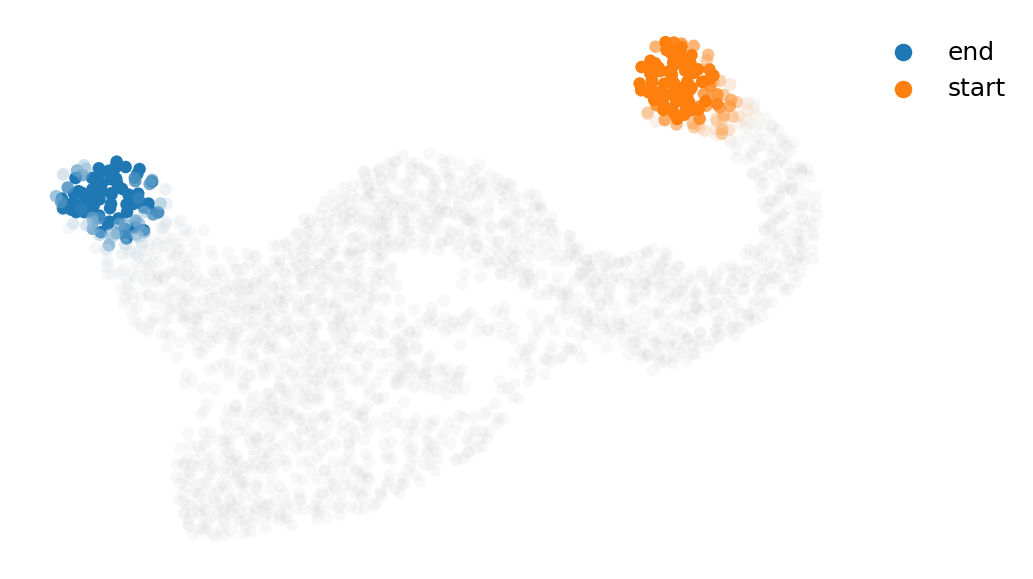

In [24]:
scv.pl.scatter(adata[ixs], basis='umap', color_gradients=ln, cmap='viridis', size=100, dpi=180,
               save='start_end.pdf')